In [1]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=569ea6017f29adb1aef68b7aa26b62a36a95efcdc98270cc510b791e94728d42
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [2]:
# Imorting necessary libraries
from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras import Model, Sequential
from tensorflow.keras import layers 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.metrics as metrics

# Setting some variables for plotting via matplotlib
plt.rcParams["figure.figsize"] = (10, 10)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rc('lines', linewidth=3)
plt.rc('font', size=15)

In [3]:
tf.__version__

'2.6.3'

In [4]:
directory_test = '../input/chest-xray/chest_xray/test/NORMAL/'
directory_train = '../input/chest-xray/chest_xray/train/NORMAL/' 
directory_val = '../input/chest-xray/chest_xray/val/NORMAL/'
image_paths_norm = sorted(list(paths.list_images(directory_test))) + \
                   sorted(list(paths.list_images(directory_train))) + \
                   sorted(list(paths.list_images(directory_val)))

# Declare a normal label list
labels_norm = ['Normal'] * len(image_paths_norm)

In [5]:
directory_test = '../input/chest-xray/chest_xray/test/PNEUMONIA/'
directory_train = '../input/chest-xray/chest_xray/train/PNEUMONIA/' 
directory_val = '../input/chest-xray/chest_xray/val/PNEUMONIA/'
image_paths_pn = sorted(list(paths.list_images(directory_test))) + \
                   sorted(list(paths.list_images(directory_train))) + \
                   sorted(list(paths.list_images(directory_val)))

# Declare a normal label list
labels_pn = ['PNEUMONIA'] * len(image_paths_pn)

In [6]:
image_paths = np.array(image_paths_norm + image_paths_pn)
labels = np.concatenate((labels_norm, labels_pn))

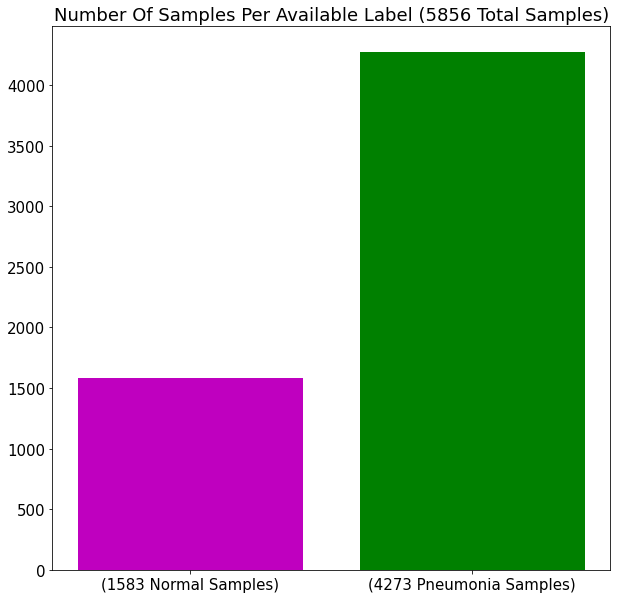

In [7]:
plt.bar([1, 2], height=[len(labels_norm), len(labels_pn)], 
        tick_label=['({0:d} Normal Samples)'.format(len(labels_norm)), 
                    '({0:d} Pneumonia Samples)'.format(len(labels_pn))], 
        color=['m', 'g'])

plt.title('Number Of Samples Per Available Label ({0:d} Total Samples)'.
          format(len(labels_norm) + len(labels_pn)))

plt.show()

In [8]:
from sklearn.model_selection import train_test_split

# Divide the image path & label arrays into train & test sets. This is done without loading images to save memory
X_train_dir, X_test_dir, y_train, y_test = train_test_split(image_paths, labels, test_size=0.3)

# Divide the test set into validation (for use during training) and test (for post-training evaulation) sets
X_val_dir, y_val = X_test_dir[:len(X_test_dir) // 2], \
                   y_test[:len(y_test) // 2]

X_test_dir, y_test = X_test_dir[len(X_test_dir) // 2:], \
                     y_test[len(y_test) // 2:]

In [9]:
# Create DataFrames for the image generator
train_df = pd.DataFrame(np.transpose([X_train_dir, y_train]), 
                        columns=['filename', 'class'])

val_df = pd.DataFrame(np.transpose([X_val_dir, y_val]), 
                      columns=['filename', 'class'])

test_df = pd.DataFrame(np.transpose([X_test_dir, y_test]), 
                       columns=['filename', 'class'])

In [10]:
train_df

,filename,class
0,../input/chest-xray/chest_xray/train/PNEUMONIA...,PNEUMONIA
1,../input/chest-xray/chest_xray/train/PNEUMONIA...,PNEUMONIA
2,../input/chest-xray/chest_xray/test/PNEUMONIA/...,PNEUMONIA
3,../input/chest-xray/chest_xray/train/PNEUMONIA...,PNEUMONIA
4,../input/chest-xray/chest_xray/train/PNEUMONIA...,PNEUMONIA
...,...,...
4094,../input/chest-xray/chest_xray/train/PNEUMONIA...,PNEUMONIA
4095,../input/chest-xray/chest_xray/train/PNEUMONIA...,PNEUMONIA
4096,../input/chest-xray/chest_xray/test/NORMAL/IM-...,Normal
4097,../input/chest-xray/chest_xray/train/PNEUMONIA...,PNEUMONIA


In [11]:
# Set the batch size for the generator and training
BATCH_SIZE = 128

# Declare an image generator for image augmentation
datagen = ImageDataGenerator(rescale = 1/255,
                             zoom_range=0.1, 
                             height_shift_range=0.05, 
                             width_shift_range=0.05,
                             rotation_range=5)


# Declare an image generator for validation & testing without generation
test_datagen = ImageDataGenerator(rescale = 1./255)

# Declare generators for training, validation, and testing from DataFrames
train_gen = datagen.flow_from_dataframe(train_df,
                                        target_size=(300, 300),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=True)

val_gen = test_datagen.flow_from_dataframe(val_df,
                                        target_size=(300, 300),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=False)

test_gen = test_datagen.flow_from_dataframe(test_df,
                                        target_size=(300, 300),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=False)

Found 4099 validated image filenames belonging to 2 classes.
Found 878 validated image filenames belonging to 2 classes.
Found 879 validated image filenames belonging to 2 classes.


In [12]:
def create_model():
    # Model input
    input_layer = layers.Input(shape=(512, 512, 1))    

    # First block
    x = layers.Conv2D(filters=64, kernel_size=3, 
                      activation='relu', padding='same')(input_layer)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.Dropout(0.1)(x)
    
    # Second block
    x = layers.Conv2D(filters=96, kernel_size=3, 
                      activation='relu', padding='same')(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.Dropout(0.1)(x)

    # Third block
    x = layers.Conv2D(filters=128, kernel_size=3, 
                      activation='relu', padding='same')(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.Dropout(0.1)(x)
    
    # Fourth block
    x = layers.Conv2D(filters=160, kernel_size=3, 
                      activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.Dropout(0.1)(x)

    # Fifth block
    x = layers.Conv2D(filters=192, kernel_size=3, 
                      activation='relu', padding='same')(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.Dropout(0.1)(x)
    
    # Sixth block
    x = layers.Conv2D(filters=224, kernel_size=3, 
                      activation='relu', padding='same')(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.Dropout(0.1)(x)
    
    # Seventh block
    x = layers.Conv2D(filters=256, kernel_size=3, 
                      activation='relu', padding='same')(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.Dropout(0.1)(x)

    # Pooling and output
    x = layers.GlobalAveragePooling2D()(x)    
    output = layers.Dense(units=1,activation='sigmoid')(x)

    # Model creation and compilation
    
    model = Model (input_layer, output)    
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [13]:
model = create_model()

2022-04-30 12:23:36.996781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-30 12:23:37.076032: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-30 12:23:37.076898: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-30 12:23:37.078282: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 512, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 96)      55392     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 96)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 96)      0     

In [15]:
history = model.fit(
    train_gen,
    epochs = 10,
    validation_data = val_gen
)

2022-04-30 12:23:42.270360: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-04-30 12:23:46.927899: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


33/33 [==============================] - 116s 3s/step - loss: 0.6508 - accuracy: 0.7329 - val_loss: 0.5856 - val_accuracy: 0.7369
Epoch 2/10
33/33 [==============================] - 87s 3s/step - loss: 0.5819 - accuracy: 0.7329 - val_loss: 0.5868 - val_accuracy: 0.7369
Epoch 3/10
33/33 [==============================] - 87s 3s/step - loss: 0.5865 - accuracy: 0.7329 - val_loss: 0.6216 - val_accuracy: 0.7369
Epoch 4/10
33/33 [==============================] - 86s 3s/step - loss: 0.5114 - accuracy: 0.7597 - val_loss: 0.5121 - val_accuracy: 0.7608
Epoch 5/10
33/33 [==============================] - 87s 3s/step - loss: 0.4239 - accuracy: 0.8068 - val_loss: 0.3695 - val_accuracy: 0.8462
Epoch 6/10
33/33 [==============================] - 87s 3s/step - loss: 0.3484 - accuracy: 0.8522 - val_loss: 0.3146 - val_accuracy: 0.8759
Epoch 7/10
33/33 [==============================] - 87s 3s/step - loss: 0.3067 - accuracy: 0.8683 - val_loss: 0.2308 - val_accuracy: 0.9226
Epoch 8/10
33/33 [============

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7fe6daea20e0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


In [16]:
from tensorflow.keras.models import load_model

In [17]:
model = load_model(r'../input/model/saved_mode_91.h5')

In [26]:
model.save('save_model_92.h5')

In [28]:
pd.DataFrame(history.history).to_csv('92_model_log.csv')

In [25]:
eval_result = model.evaluate_generator(test_gen, 624)
print('loss rate at evaluation data :', eval_result[0])
print('accuracy rate at evaluation data :', eval_result[1])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


loss rate at evaluation data : 0.1899641752243042
accuracy rate at evaluation data : 0.9294652938842773


Text(0.5, 1.0, 'Accuracy Evolution')

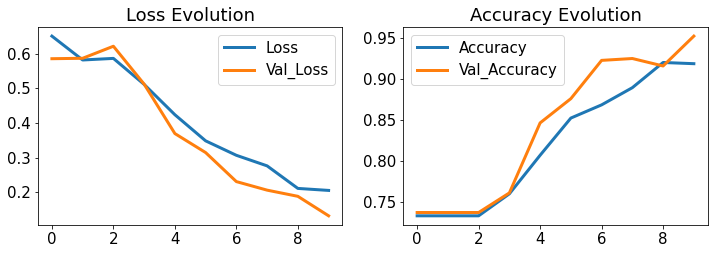

In [29]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [30]:
test_steps = test_gen.samples // 128

predictions = model.predict(test_gen, steps=test_steps).flatten()
y_true = test_gen.classes[:len(predictions)]

In [31]:
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(y_true, predictions > 0.5)

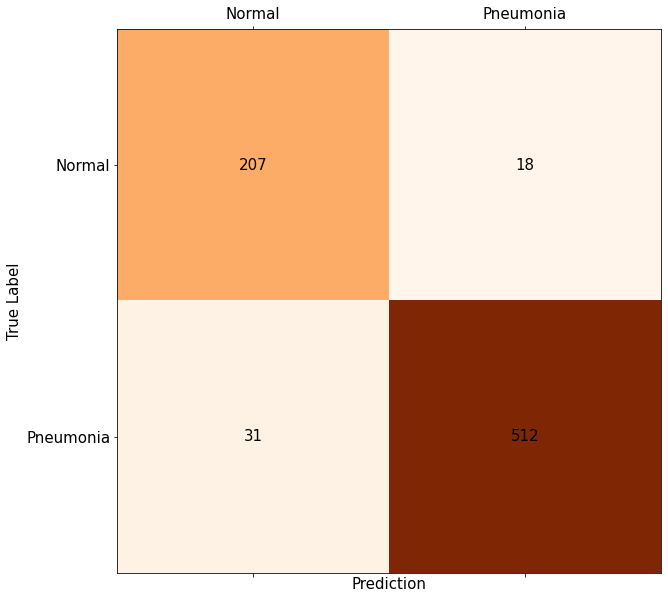

In [32]:
fig, ax = plt.subplots()

ax.matshow(confusion_mat, cmap=plt.cm.Oranges)

ax.set_xlabel('Prediction')
ax.set_ylabel('True Label')

tick_labels = ['Normal', 'Pneumonia']

ax.set_xticks(range(len(tick_labels)))
ax.set_yticks(range(len(tick_labels)))
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)

for i in range(len(tick_labels)):
    for j in range(len(tick_labels)):
        ax.text(j, i, confusion_mat[i, j],
               ha='center', va='center')
        
plt.show()

In [43]:
# Set the batch size for the generator and training
BATCH_SIZE = 128

# Declare an image generator for image augmentation
datagen = ImageDataGenerator(rescale = 1/255,
                             zoom_range=0.1, 
                             height_shift_range=0.05, 
                             width_shift_range=0.05,
                             rotation_range=5)


# Declare an image generator for validation & testing without generation
test_datagen = ImageDataGenerator(rescale = 1./255)

# Declare generators for training, validation, and testing from DataFrames
train_gen = datagen.flow_from_dataframe(train_df,
                                        target_size=(512, 512),
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=True)

val_gen = test_datagen.flow_from_dataframe(val_df,
                                        target_size=(512, 512),
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=False)

test_gen = test_datagen.flow_from_dataframe(test_df,
                                        target_size=(512, 512),
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        color_mode = "grayscale",
                                        shuffle=False)

Found 4099 validated image filenames belonging to 2 classes.
Found 878 validated image filenames belonging to 2 classes.
Found 879 validated image filenames belonging to 2 classes.


In [35]:
from tensorflow.keras.preprocessing.image import array_to_img

def plot_image(image, prediction, label):
      
    label_names = ['Normal', 'Pneumonia']    
        
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(array_to_img(image * 255), interpolation='nearest', cmap='grays')
    
    if prediction <= 0.5:
        predicted_label = 0
    else:
        predicted_label = 1

    if predicted_label == label:
        color = 'blue'
    else:
        color = 'red' 
    
    plt.xlabel("{} {:2.0f}% \n ({})".format(label_names[predicted_label], 100 * prediction[0], label_names[label]), color=color)

In [44]:
images.shape

(128, 512, 512, 3)

In [49]:
model.output

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'output')>

In [46]:
images, labels = next(iter(test_gen))
y_pred = model.predict(images)

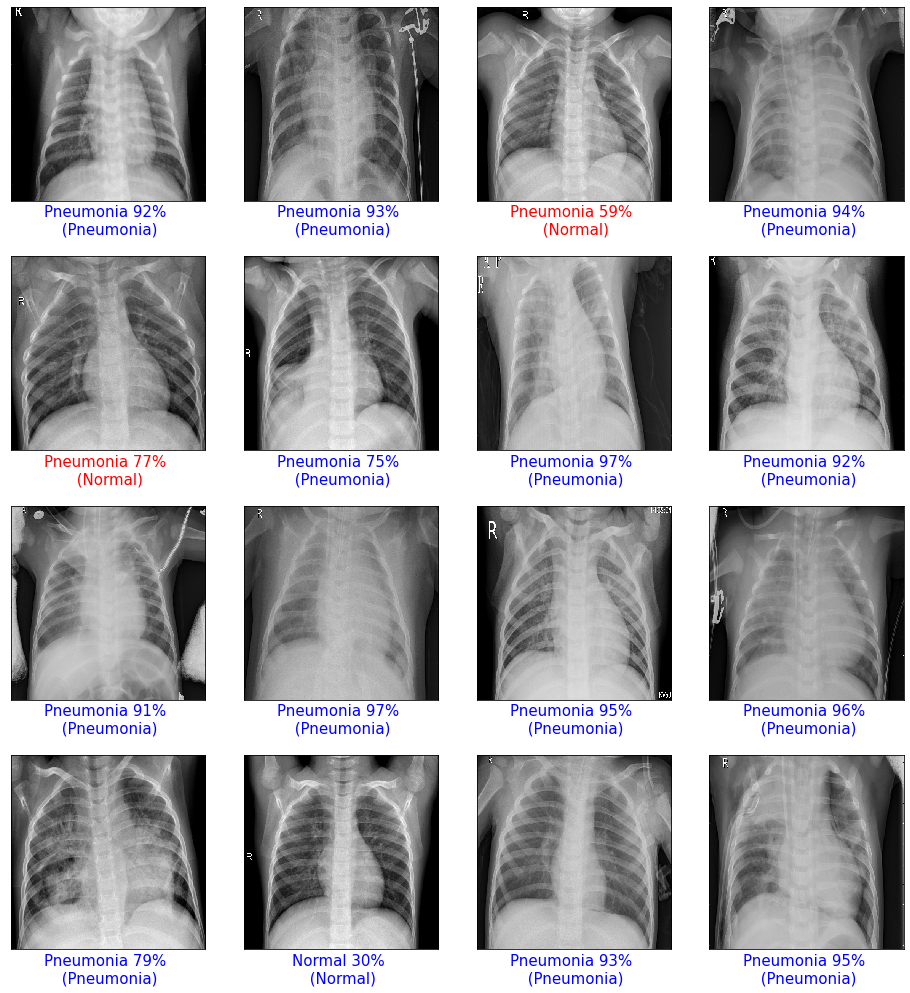

In [50]:
num_rows = 4
num_cols = 4
labels = labels.astype('int')
num_images = num_rows * num_cols
plt.figure(figsize=(2*2*num_cols, 2.2*2*num_rows))

for i in range(num_images):
    
    plt.subplot(num_rows, num_cols, i+1)
#     print(y_pred[i])
    plot_image(images[i], y_pred[i], labels[i])
plt.show()